In [1]:
import sys
import os
root_dir = os.getcwd().replace('/Notebooks','')
sys.path.insert(1, root_dir)
sys.path.append('../modules/')
import pandas as pd
import numpy as np
from datetime import datetime as dt
import glob
from zipline.utils.run_algo import load_extensions
from zipline.data import bundles
from zipline.data.data_portal import DataPortal
from zipline.utils.calendar_utils import get_calendar
import os
load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)
from zipline.data.bundles import register, unregister
from zipline.data.bundles.csvdir import csvdir_equities
from zipline.utils.calendar_utils import register_calendar, get_calendar
# from exchange_calendars.exchange_calendar_xdse import XDSExchangeCalendar
from logbook import (NestedSetup, NullHandler, Logger, StreamHandler, StderrHandler, 
                     INFO, WARNING, DEBUG, ERROR)
from zipline.api import (order, 
                         record, 
                         symbol,
                         get_datetime,
                         order_target_percent,
                         order_target_value,
                         order_value,
                         set_benchmark,
                         get_open_orders)
from zipline import run_algorithm
from zipline.utils.calendar_utils import get_calendar
from zipline.api import order_target, record, symbol
from pyfolio.tears import create_full_tear_sheet
from pyfolio.utils import extract_rets_pos_txn_from_zipline
import seaborn as sns
import quantstats as qs
import yfinance as yf
from hurst import compute_Hc, random_walk
import warnings
warnings.filterwarnings('ignore')
import ensemble_trading_strategy as ets
%load_ext autoreload
%autoreload 2

## Backtesting with Ensemble Traging Strategy

In [38]:
start = '2018-01-01'
end = '2023-01-01'
capital_base = 10000
calendar = get_calendar('NYSE')
symb = "AAPL"
bundle_data = bundles.load("sp50")
window = 90

def initialize(context):
    context.i = 0
    sids = bundle_data.asset_finder.sids
    context.assets = bundle_data.asset_finder.retrieve_all(sids)
    context.buy_counter = {}


def handle_data(context, data):
    # Skip first 90 days to get full windows
    context.i += 1
    if context.i < window+1:
        return
    
    # Only backtesting first 10 assets due to lack of computational power 
    for asset in context.assets[:10]:
        df = data.history(asset,['open','high','low','close','volume'],bar_count=window,frequency='1d')
        curr_price = data.current(asset,'price')
        signal = ets.group3_ensemble_model_signals(df)
        curr_date = data.history(asset, 'price', 2, '1d').index[-1]
        # print(f'Signal for date: {curr_date} - {signal}')
        # signal = get_signal(df)
        buy_count = context.buy_counter.get(asset.symbol, 0)

        if signal == 1 and buy_count < 2:
            order_target_percent(asset, 0.2)
            context.buy_counter[asset.symbol] = buy_count + 1
        elif signal == -1 and buy_count != 0:
            order_target_percent(asset, 0,stop_price=(curr_price * 0.9))
            del context.buy_counter[asset.symbol]
        else:
            pass
    

result = run_algorithm(start=pd.Timestamp(start),
                        end=pd.Timestamp(end),
                        initialize=initialize,
                        handle_data=handle_data,
                        capital_base=capital_base,
                        trading_calendar=calendar,
                        bundle='sp50',
                        data_frequency='daily',
                        )


## Quantstats Result

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2018-05-14   2018-05-14
End Period                 2022-12-30   2022-12-30
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          40.76%       183.77%
Mean Active Return         0.0%         0.09%
CAGR﹪                     5.23%        16.82%

Sharpe                     0.44         0.74
Prob. Sharpe Ratio         82.88%       94.41%
Smart Sharpe               0.37         0.62
Sortino                    0.62         1.07
Smart Sortino              0.52         0.9
Sortino/√2                 0.44         0.76
Smart Sortino/√2           0.37         0.64
Omega                      1.15         1.15

Max Drawdown               -33.92%      -51.0%
Longest DD Days            361          368
Volatility (ann.)          22.11%       42.73%
R^2                        0.82         0.82
Calmar             

None

0.055830584948369344





,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-12-28,2022-10-14,2022-12-30,368,-51.002922,-49.814454
2,2020-02-20,2020-03-23,2020-07-21,153,-46.564786,-42.733221
3,2018-09-17,2018-12-24,2019-03-20,185,-39.159097,-35.697097
4,2021-02-16,2021-03-08,2021-06-25,130,-16.411642,-14.484394
5,2020-09-03,2020-09-23,2020-11-05,64,-14.769527,-13.898874


Average Long Exposure = 32967.61011517077
Average Short Exposure = 0.0
Average Net Leverage = 1.3608644621292807
Average Gross Leverage = 1.3608644621292807
Max Leverage = 2.1842331891933964



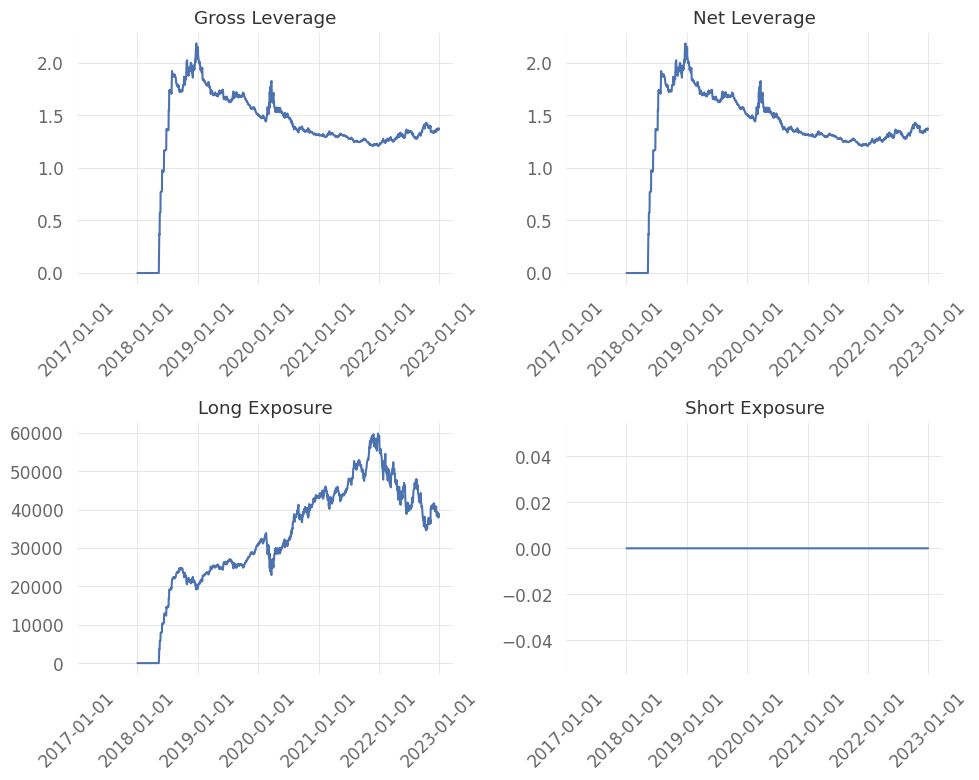

AAPL ABT ADBE AEP AES AFL ALGN AMD AMT AOS


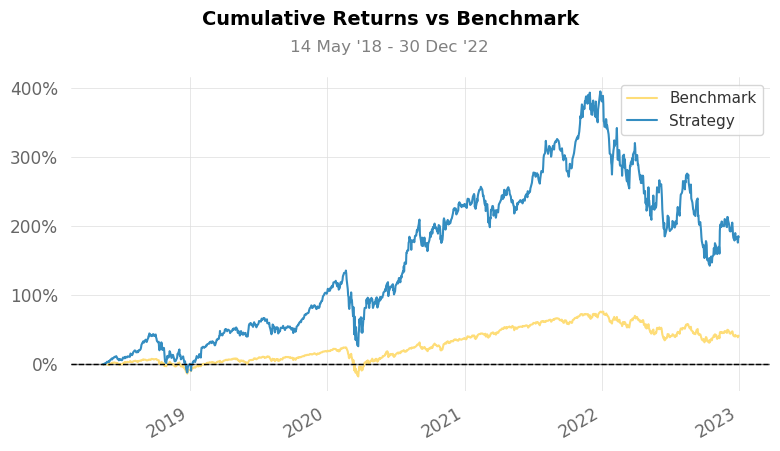

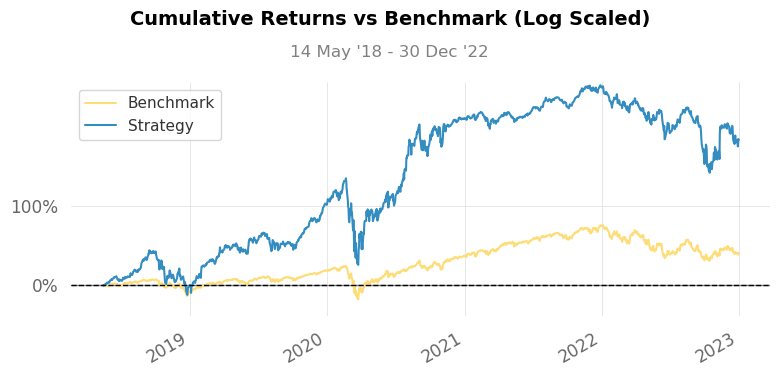

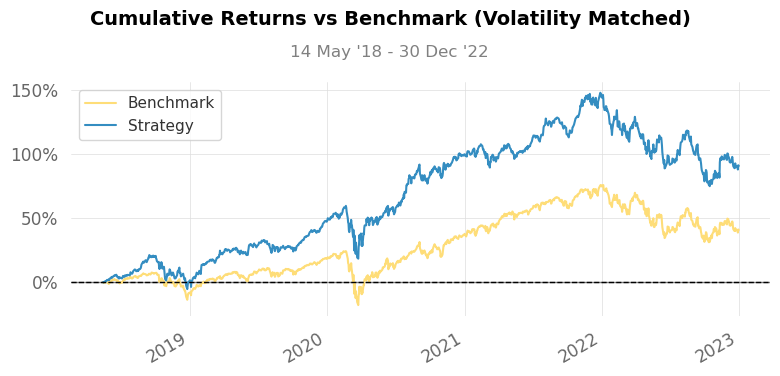

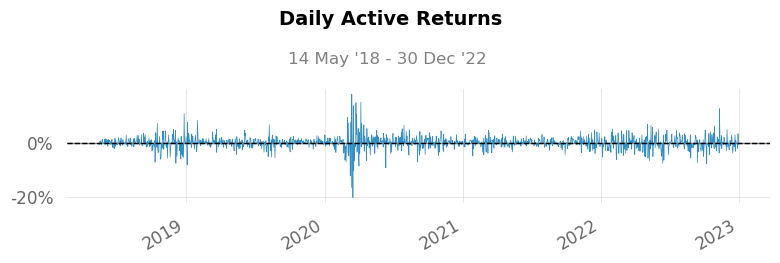

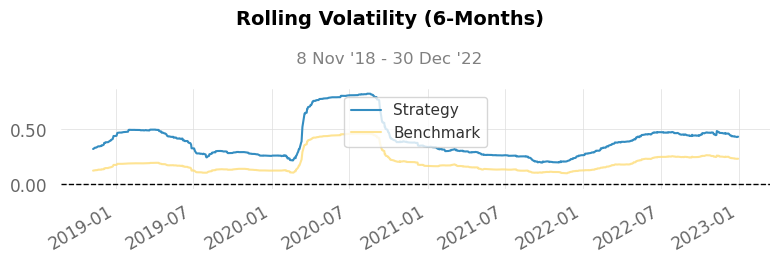

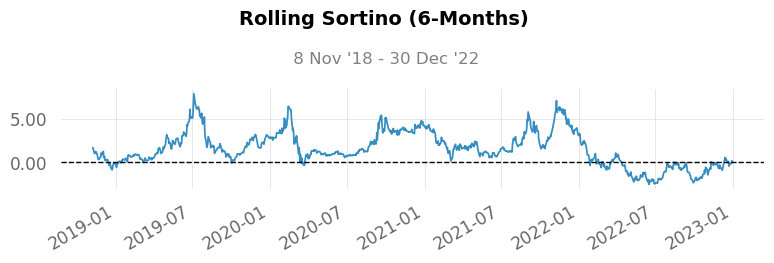

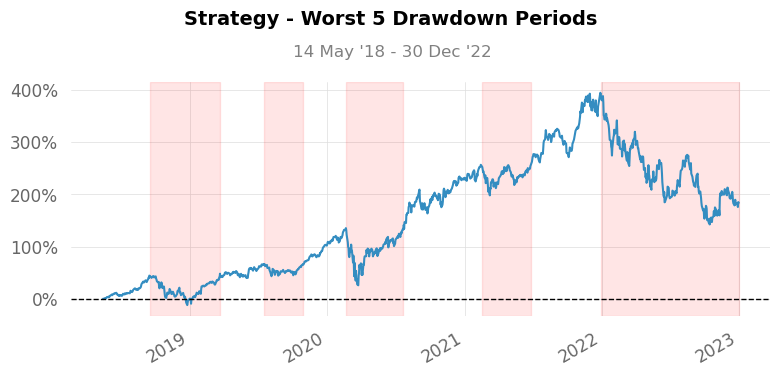

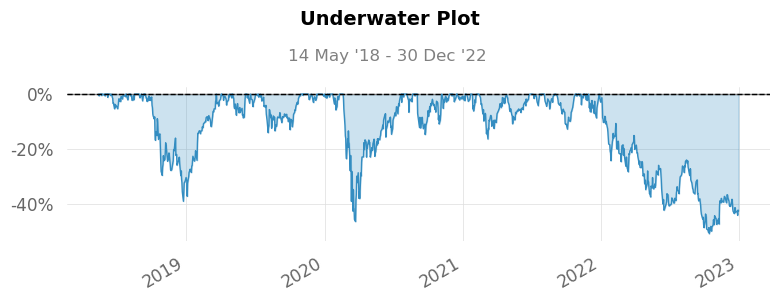

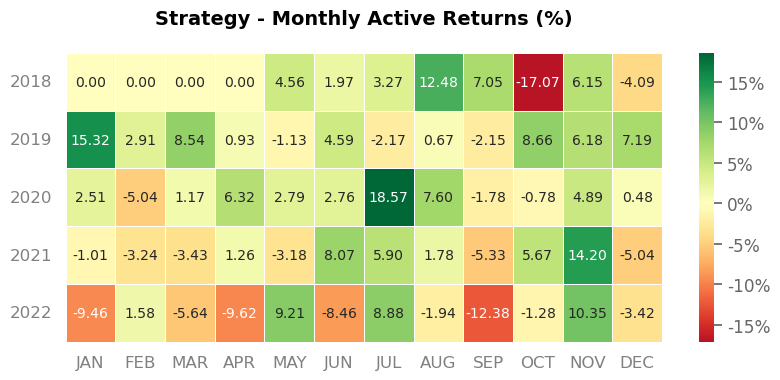

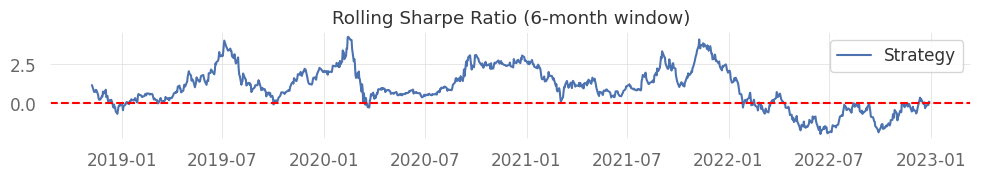

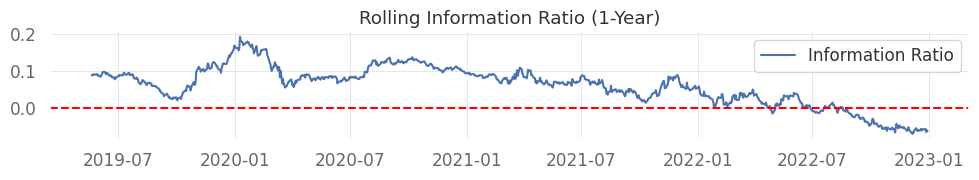

[*********************100%%**********************]  1 of 1 completed


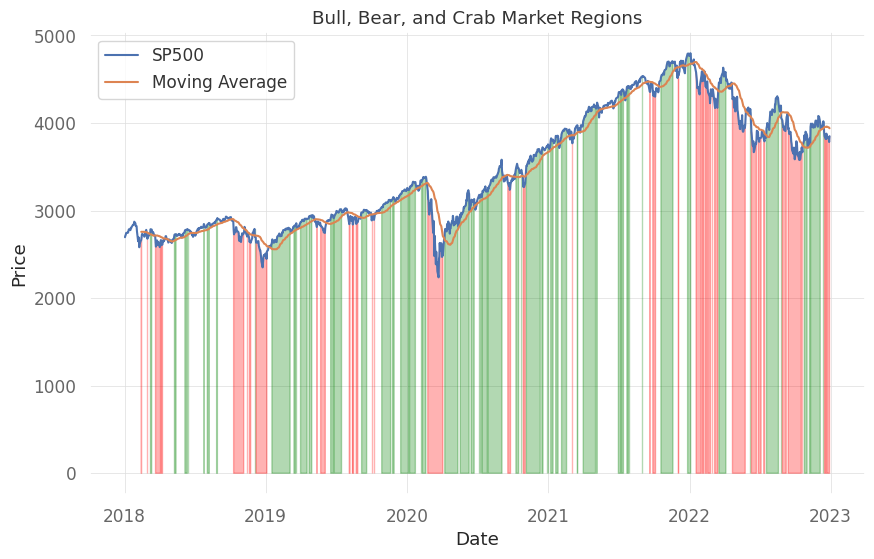

Total Trades: 13
Daily Trades: 1
Weekly Trades: 5
Monthly Trades: 21





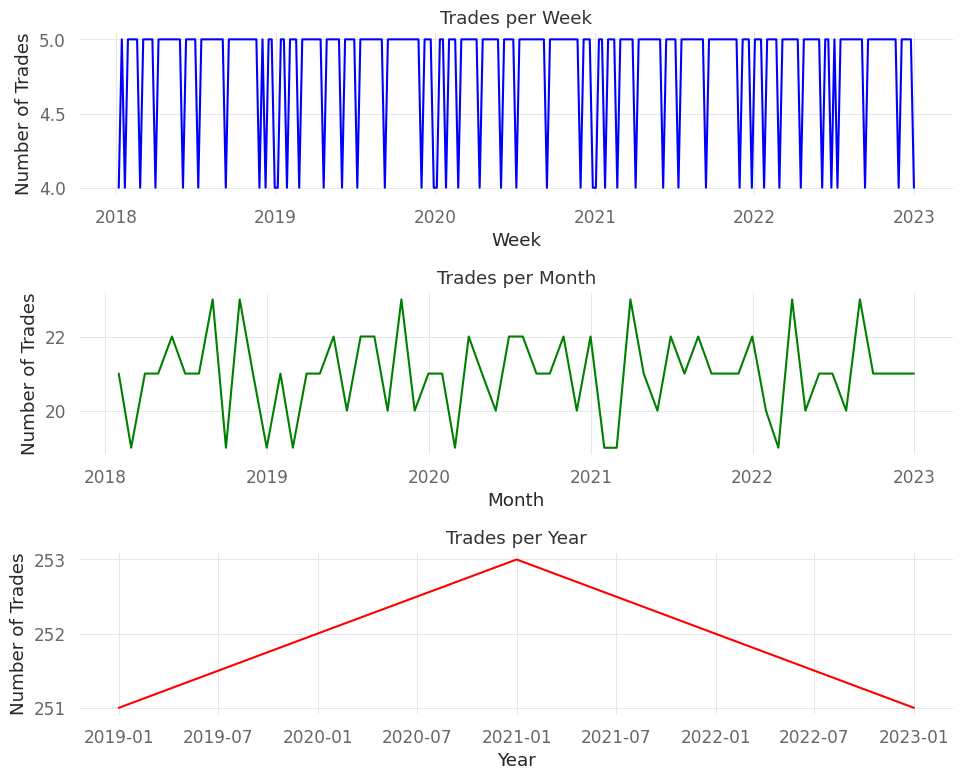

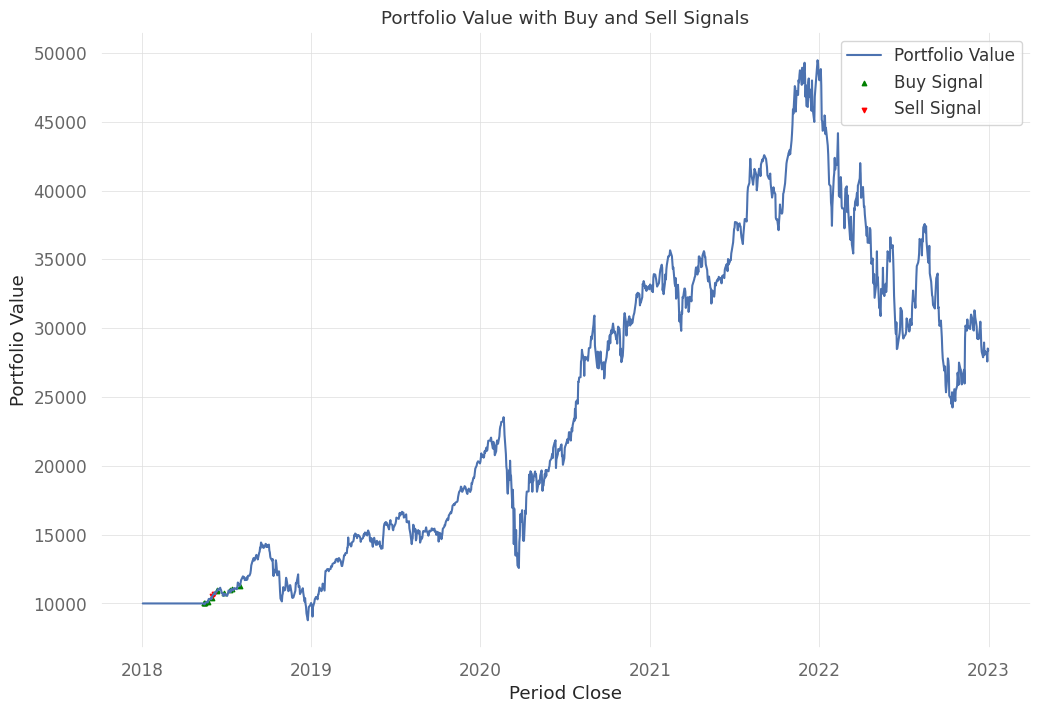

In [39]:
start = result.index[0]
end = result.index[-1]
benchmark = yf.download('^GSPC', start=start, end=end)['Adj Close'].pct_change()
result.index = pd.to_datetime(result.index).tz_convert(None)
result.index = benchmark.index    
qs.reports.full(result['returns'], benchmark = benchmark, match_dates=True, figsize=(8, 4), df = result)